In [3]:
import pandas as pd
from pandas_datareader import data
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from utils import load_financial_data, plot_ts, plot_multi_ts

import quantstats as qs

In [4]:
import torch
# For reproducibility
torch.manual_seed(42)

In [14]:
torch.cuda.is_available()

True

In [5]:
# Overriding the Yahoo Finance data reader
yf.pdr_override()

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [6]:
# Define the start date
start_date = '2013-01-01'
# Define the end date
end_date = '2022-12-31'
# Define the ticker of Google
ticker = 'AAPL'
# ticker = 'ENPH'
# Load the data
security_data=load_financial_data(ticker, start_date, end_date)

File data found...reading META data


In [7]:
security_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,27.440001,28.180000,27.420000,28.000000,27.970324,69846400
2013-01-03,27.879999,28.469999,27.590000,27.770000,27.740568,63140600
2013-01-04,28.010000,28.930000,27.830000,28.760000,28.729517,72715400
2013-01-07,28.690001,29.790001,28.650000,29.420000,29.388819,83781800
2013-01-08,29.510000,29.600000,28.860001,29.059999,29.029200,45871300
...,...,...,...,...,...,...
2022-12-23,116.029999,118.180000,115.540001,118.040001,117.914894,17796600
2022-12-27,117.930000,118.599998,116.050003,116.879997,116.756119,21392300
2022-12-28,116.250000,118.150002,115.510002,115.620003,115.497459,19612500


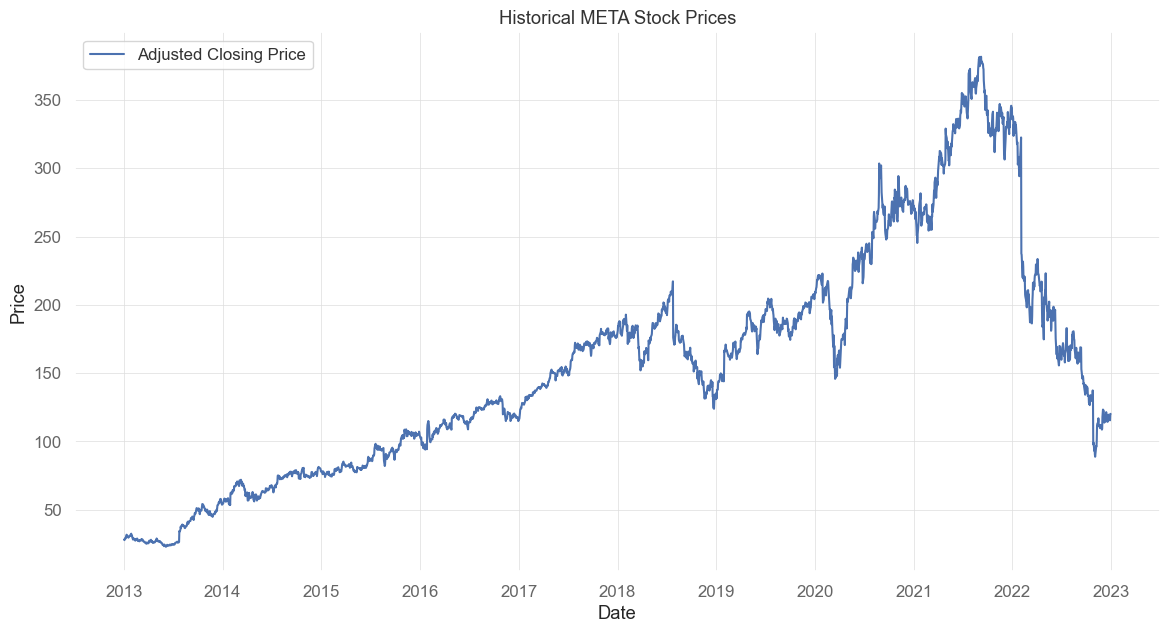

In [8]:
plot_ts(
    data=security_data["Adj Close"], 
    title=f"Historical {ticker} Stock Prices",
    label_ts="Adjusted Closing Price",
    x_label="Date",
    y_label="Price",
)

In [9]:
security_data.shape

(2518, 6)

In [10]:
# Define the start date
start_date = '2023-01-01'
# Define the end date
end_date = '2023-12-31'
# Load the data
validation_data=load_financial_data(ticker, start_date, end_date)

File data found...reading META data


In [11]:
# Define the start date
start_date = '2023-01-01'
# Define the end date
end_date = '2023-12-31'
# Load the data
test_data=load_financial_data(ticker, start_date, end_date)

File data found...reading META data


In [12]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [17]:
import typing
import pandas as pd
import numpy as np
import numpy.typing as npt
from utils import load_financial_data
from markov import *
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import AdamW
from models import *
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class SimpleMLP(nn.Module):

    def __init__(self, 
                 lookback: int=5, 
                 layer_dims: list[int] = []
                ) -> None:
        super().__init__()

        self.linear_layers = []
        prev_features = lookback * len(STATE_TO_NUM)
        for dim in layer_dims:
            self.linear_layers.append(nn.Linear(
                in_features=prev_features,
                out_features=dim,
            ))
            prev_features = dim
        self.linear_layers.append(nn.Linear(
            in_features=prev_features,
            out_features=3,
        ))

        self.linear_layers = nn.Sequential(*self.linear_layers)
        
    def forward(self, x):
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x


In [19]:
class SimpleLSTM(nn.Module):

    def __init__(self, 
                 lookback: int=5, 
                 hidden_size: int=16,
                ) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.lookback = lookback

        self.lstm = nn.LSTM(
            input_size=len(STATE_TO_NUM),
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True,
        )

        self.linear = nn.Linear(
            in_features=self.lookback * self.hidden_size,
            out_features=3,
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        # print(x.shape)
        x = x.reshape((-1, self.lookback * self.hidden_size))
        x = F.tanh(x)
        x = self.linear(x)
        x = F.softmax(x, dim=1)
        # print(x.shape)
        return x


In [26]:
class StockData(Dataset):
    def __init__(self, x_data, y_data, threshold: int=3) -> None:
        super().__init__()
        
        self.x = np.array(x_data).reshape((len(x_data), -1))
        y_data = np.array(y_data).reshape((len(y_data), -1))
        self.threshold = threshold

        self.x = np.array([one_hot(arr - STATE_TO_NUM["High Decrease"], len(STATE_TO_NUM)) for arr in self.x])
        self.x = torch.tensor(self.x, dtype=torch.float32)

        self.y = np.zeros((len(y_data), 3))
        for i, y in enumerate(y_data):
            x = self.x[i]
            past_ups = sum(x[x > STATE_TO_NUM["Neutral"]])
            past_downs = -sum(x[x < STATE_TO_NUM["Neutral"]])

            future_ups = sum(y[y > STATE_TO_NUM["Neutral"]])
            future_downs = -sum(y[y < STATE_TO_NUM["Neutral"]])

            if future_ups >= 2 * future_downs and \
                (past_ups >= 2 * future_downs or past_downs >= 2 * past_ups):
                self.y[i][2] = 1
            elif future_downs >= 2 * future_ups and \
                (past_downs >= 2 * future_downs or past_ups >= 2 * past_downs):
                self.y[i][0] = 1
            else:
                self.y[i][1] = 1

        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])



class MLStrategy(MarkovStrategy):

    def __init__(self, 
                 price: pd.Series, 
                 valid_data: pd.Series, 
                 test_data: pd.Series,
                 threshold_to_buy: int=2, 
                 threshold_to_sell: int=2,
                 lookback: int=5,
                 forward: int=5,
                 batch_size: int=128,
                ) -> None:
        self.historical_price: pd.Series = price
        self.threshold_to_buy = threshold_to_buy
        self.threshold_to_sell = threshold_to_sell
        self.lookback: int = lookback
        self.forward: int = forward

        # self.model = SimpleMLP(
        #     lookback=self.lookback,
        #     layer_dims=[
        #         16,
        #         16,
        #         8,
        #     ]
        # )

        self.model = SimpleLSTM(
            lookback=lookback,
            # hidden_size=16,
        )

        self.daily_return: pd.Series = self.historical_price.pct_change()
        self.quantiles_inc: pd.Series = self.daily_return[self.daily_return > 0].quantile([0.25, 0.5, 0.75])
        self.quantiles_dec: pd.Series = self.daily_return[self.daily_return < 0].quantile([0.25, 0.5, 0.75])

        self.historical_state: npt.ArrayLike = self.define_states(self.daily_return)
        self.batch_size = batch_size
        self.train_data = self.prepare_data(self.historical_state, self.lookback, self.forward, shuffle=True)

        historical_valid_state: npt.ArrayLike = self.define_states(valid_data.pct_change())
        self.valid_data = self.prepare_data(historical_valid_state, self.lookback, self.forward, shuffle=True)

        # historical_test_state: npt.ArrayLike = self.define_states(test_data.pct_change())
        self.test_price = test_data
        # self.test_data = self.prepare_data(historical_test_state, self.lookback, self.forward, shuffle=False)

    def define_states(self, data: pd.Series) -> npt.NDArray:
        """
        Define states based on quartiles of daily returns.
        """
        
        conditions = {
            'High Increase': data > self.quantiles_inc[0.75], 
            'Moderate Increase': (self.quantiles_inc[0.5] < data) & (data <= self.quantiles_inc[0.75]),
            'Slight Increase': (self.quantiles_inc[0.25] < data) & (data <= self.quantiles_inc[0.5]),
            
            'Neutral': (self.quantiles_dec[0.75] < data) & (data <= self.quantiles_inc[0.25]),
            
            'Slight Decrease': (self.quantiles_dec[0.5] < data) & (data <= self.quantiles_dec[0.75]),
            'Moderate Decrease': (self.quantiles_dec[0.25] < data) & (data <= self.quantiles_dec[0.5]),
            'High Decrease':data < self.quantiles_dec[0.25], 
        }

        return np.select(list(conditions.values()), list(conditions.keys()), default='Neutral')

    def update_transition_matrix(self, prev_state, next_state) -> None:
        self.transition_matrix.loc[prev_state, next_state] += 1

    def prepare_data(self, states, lookback: int=5, forward: int=5, shuffle: bool=True) -> DataLoader:
        """
        Prepare the data
        """

        x_data = []
        y_data = []

        for i in range(lookback - 1, len(states) - forward):
            prev = np.array(list(map(lambda x: STATE_TO_NUM[x], states[i-lookback+1:i+1])))
            curr = np.array(list(map(lambda x: STATE_TO_NUM[x], states[i+1:i+forward+1])))
            x_data.append(prev)
            y_data.append(curr)

        stock_data = StockData(x_data, y_data, self.threshold_to_buy)
        return DataLoader(stock_data, batch_size=self.batch_size, shuffle=shuffle)
    

    def train(self, 
              lr: float=1e-5,
              epochs: int=100,
            ) -> None:
        
        model = self.model
        loss_fn = nn.CrossEntropyLoss()
        optimizer = AdamW(
            model.parameters(), 
            lr=lr,
        )

        for epoch in tqdm(range(epochs)):
            train_loss_epoch = 0
            train_num_correct = 0
            # print(f"Epoch {epoch}:")

            model.train()
            for (x, y) in self.train_data:
                batch_size = x.shape[0]
                x = x#.reshape(batch_size, -1) # flatten
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                train_loss_epoch += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_num_correct += torch.sum(y_pred.argmax(dim=1) == y.argmax(dim=1))

            valid_loss_epoch = 0
            valid_num_correct = 0
            model.eval()
            with torch.no_grad():
                for (x, y) in self.valid_data:
                    batch_size = x.shape[0]
                    x = x#.reshape(batch_size, -1) # flatten
                    y_pred = model(x)
                    loss = loss_fn(y_pred, y)
                    valid_loss_epoch += loss.item()
                    # print("prediction:", y_pred.argmax(dim=1))
                    # print("ground truth:", y.argmax(dim=1))
                    valid_num_correct += torch.sum(y_pred.argmax(dim=1) == y.argmax(dim=1))

            
            # print(f"Trainning Loss: {train_loss_epoch / len(self.train_data):.6f}")
            # print(f"Trainning Accuracy: {train_num_correct / len(self.train_data.dataset):.6f}")
            # print(f"Validation Loss: {valid_loss_epoch / len(self.valid_data):.6f}")
            # print(f"Validation Accuracy: {valid_num_correct / len(self.valid_data.dataset):.6f}")
            # print("=" * 50)

    
    def backtest(self, 
                 initial_cash: int | float, 
                 num_share_per_trade: None | float | int=None,
                 limit_borrow: int | float=0,
                 limit_num_shorts: int | float=0,
                 allin: bool=False,
                 halfin: bool=False,
                 rsi_window: int=14,
                 percentage: float=0.3,
                ) -> pd.DataFrame:
        price = self.test_price
        daily_return = price.pct_change()
        daily_return.iloc[0] = 1

        states = self.define_states(daily_return)
        
        position = 0
        cur_cash = initial_cash
        cash = [cur_cash for _ in range(self.lookback-1)]
        positions = [0 for _ in range(self.lookback-1)]
        signals = [0 for _ in range(self.lookback-1)]

        if num_share_per_trade is None:
            num_share_per_trade = initial_cash / price.iloc[0]
        
        self.model.eval()
        with torch.no_grad():
            for i in tqdm(range(self.lookback - 1, len(daily_return))):
                # cur_state = "-".join(states[i-self.lookback+1:i+1])
                cur_state = np.array(list(map(lambda x: STATE_TO_NUM[x], states[i-self.lookback+1:i+1])))
                cur_state = torch.tensor(one_hot(cur_state - STATE_TO_NUM["High Decrease"], len(STATE_TO_NUM)), 
                                         dtype=torch.float32).unsqueeze(0)#.reshape(1, -1)
                signal_pred = self.model(cur_state).argmax(dim=1).item() - 1
                signal = 0
                
                delta = price.iloc[max(0, i - rsi_window + 1):i+1].diff()
                gain = delta[delta > 0].mean()
                loss = -delta[delta < 0].mean()
                
                rsi = gain / loss
                rsi = 100 - (100 / (1 + rsi))
                
                if allin:
                    num_share_per_trade = cur_cash / price.iloc[i]
                if halfin:
                    num_share_per_trade = cur_cash / price.iloc[i] / 2
                    
                num_share_per_trade = percentage * cur_cash / price.iloc[i]

                if signal_pred == 1 and \
                rsi < 50 and \
                cur_cash - num_share_per_trade * price.iloc[i] >= -limit_borrow:
                    position += num_share_per_trade
                    cur_cash -= num_share_per_trade * price.iloc[i]
                    signal = 1
            
                if signal_pred == -1 and \
                rsi > 50 and \
                position - num_share_per_trade >= -limit_num_shorts:
                    position -= num_share_per_trade
                    cur_cash += num_share_per_trade * price.iloc[i]
                    signal = -1
                
                signals.append(signal)
                cash.append(cur_cash)
                positions.append(position)

        positions = np.array(positions) * price
        cash = np.array(cash)
        wealth = cash + positions

        performance = pd.DataFrame(index=price.index)
        performance["price"] = price
        performance["daily_return"] = daily_return
        performance["signals"] = signals
        performance["cash"] = cash
        performance["positions"] = positions
        performance["wealth"] = wealth

        return performance




def ml_train(
    train_start_date: str,
    train_end_date: str,
    valid_start_date: str,
    valid_end_date: str,
    test_start_date: str,
    test_end_date: str,
    ticker: str,
    threshold_to_buy: int=2, 
    threshold_to_sell: int=2,
    lookback: int=14,
    forward: int=7
) -> MLStrategy:
    
    security_data = load_financial_data(ticker, train_start_date, train_end_date)
    validation_data = load_financial_data(ticker, valid_start_date, valid_end_date)
    test_data = load_financial_data(ticker, test_start_date, test_end_date)

    markovian_strategy = MLStrategy(
        price=security_data["Adj Close"],
        valid_data=validation_data["Adj Close"],
        test_data=test_data["Adj Close"],
        threshold_to_buy=8,
        threshold_to_sell=8,
        lookback=lookback,
        forward=forward,
    )

    return markovian_strategy


def ml_test(
    markovian_strategy: MLStrategy,
    initial_cash: int | float,
    num_share_per_trade: float | int | None=None,
    limit_borrow: int | float=0,
    limit_num_shorts: int | float=0,
    allin: bool=False,
    halfin: bool=False,
) -> pd.DataFrame:
    
    performance = markovian_strategy.backtest(
        initial_cash=initial_cash,
        num_share_per_trade=num_share_per_trade,
        limit_borrow=limit_borrow,
        limit_num_shorts=limit_num_shorts,
        allin=allin,
        halfin=halfin
    )
    return performance


def ml_benchmark(
    ticker: str,
    train_start_date: str,
    train_end_date: str,
    valid_start_date: str,
    valid_end_date: str,
    test_start_date: str,
    test_end_date: str,
    lookback: int,
    forward: int,
    initial_cash: int | float,
    num_share_per_trade: float | int | None=None,
    limit_borrow: int | float=0,
    limit_num_shorts: int | float=0,
) -> pd.DataFrame:
    
    markovian_strategy = ml_train(
        train_start_date=train_start_date,
        train_end_date=train_end_date,
        valid_start_date=valid_start_date,
        valid_end_date=valid_end_date,
        test_start_date=test_start_date,
        test_end_date=test_end_date,
        ticker=ticker,
        lookback=lookback,
        forward=forward,
    )

    markovian_strategy.train(
        epochs=100,
        lr=1e-2,
    )

    markov_performance = ml_test(
        markovian_strategy=markovian_strategy,
        initial_cash=initial_cash,
        num_share_per_trade=num_share_per_trade,
        limit_borrow=limit_borrow,
        limit_num_shorts=limit_num_shorts
    )

    return markov_performance

In [27]:
markovian_strategy = MLStrategy(
        price=security_data["Adj Close"],
        valid_data=validation_data["Adj Close"],
        test_data=test_data["Adj Close"],
        threshold_to_buy=8,
        threshold_to_sell=8,
        lookback=7,
        forward=5,
    )

markovian_strategy.train(
    epochs=50,
    lr=5e-2,
)

100%|██████████| 50/50 [00:07<00:00,  6.73it/s]


In [28]:
markovian_performance = markovian_strategy.backtest(
    initial_cash=1e3,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=0,
    allin=False,
    halfin=False,
    rsi_window=14
)
markovian_performance

100%|██████████| 244/244 [00:00<00:00, 643.62it/s]


,price,daily_return,signals,cash,positions,wealth
Date,,,,,,
2023-01-03,124.607788,1.000000,0,1000.000000,0.000000,1000.000000
2023-01-04,127.235008,0.021084,0,1000.000000,0.000000,1000.000000
2023-01-05,126.805458,-0.003376,0,1000.000000,0.000000,1000.000000
2023-01-06,129.882202,0.024263,0,1000.000000,0.000000,1000.000000
2023-01-09,129.332779,-0.004230,0,1000.000000,0.000000,1000.000000
...,...,...,...,...,...,...
2023-12-22,353.015472,-0.001977,0,50.955316,1324.990583,1375.945898
2023-12-26,354.453918,0.004075,-1,66.241910,1315.102980,1381.344890
2023-12-27,357.450714,0.008455,0,66.241910,1326.221759,1392.463669


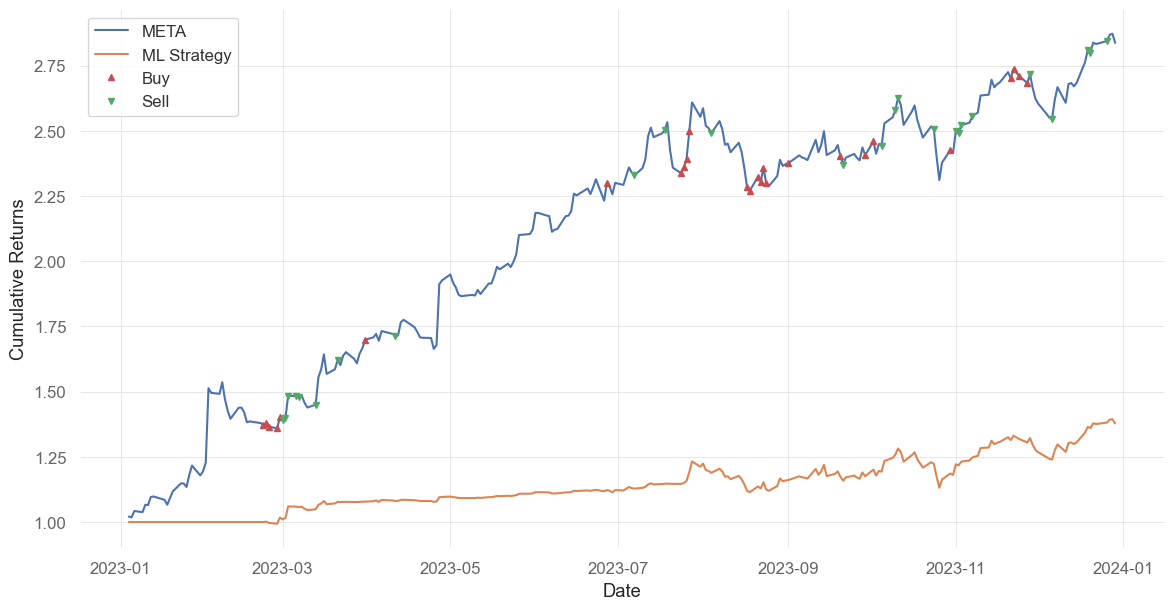

In [29]:
price = test_data["Adj Close"]
# price = security_data["Adj Close"]

# Plot both cumulative returns on the same chart 
plt.figure(figsize=(14, 7)) 
plt.plot(price.index, (1 + price.pct_change()).cumprod(), label=ticker) 
plt.plot(markovian_performance.index, (1 + markovian_performance.wealth.pct_change()).cumprod(), label='ML Strategy')

plt.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, (1 + price.pct_change()).cumprod()[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
plt.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, (1 + price.pct_change()).cumprod()[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")


plt.xlabel('Date') 
plt.ylabel('Cumulative Returns') 
plt.legend() 
plt.show()

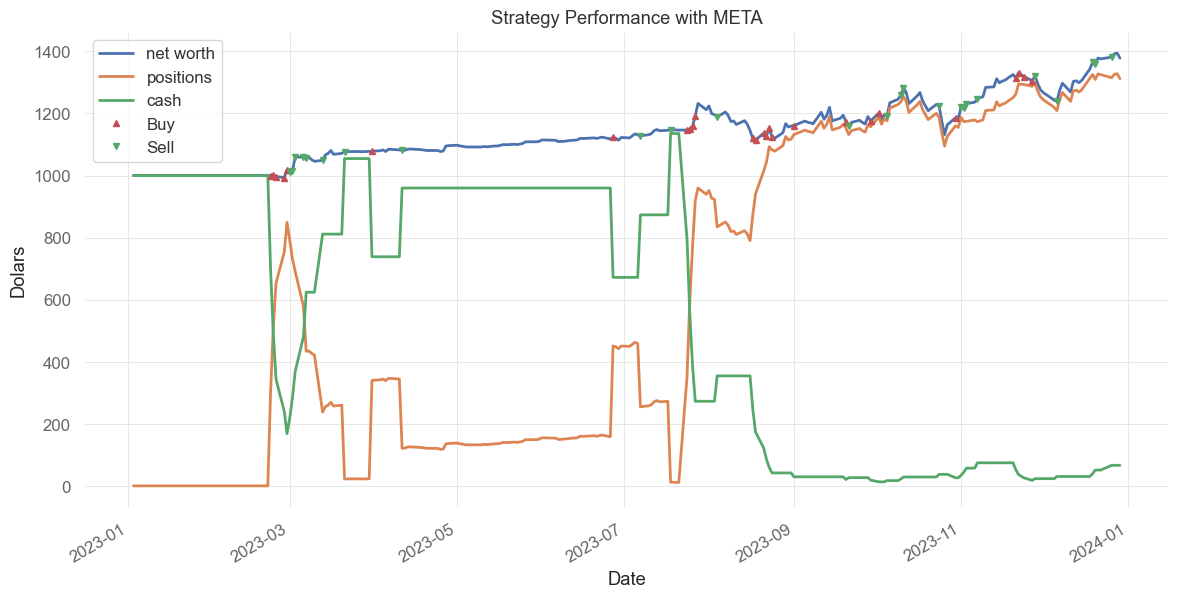

In [30]:
test_data.index = pd.DatetimeIndex(test_data.index)
price = test_data["Adj Close"]
# price = security_data["Adj Close"]
buy_and_hold = price

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111, ylabel = 'Price in USD')
markovian_performance.wealth.plot(ax=ax1, lw=2., label="net worth")
markovian_performance.positions.plot(ax=ax1, lw=2., label="positions")
markovian_performance.cash.plot(ax=ax1, lw=2., label="cash")

ax1.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, markovian_performance.wealth[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
ax1.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, markovian_performance.wealth[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")

plt.xlabel("Date")
plt.ylabel("Dolars")
plt.title(f"Strategy Performance with {ticker}")
plt.legend()
plt.show()

In [31]:
returns = markovian_performance.wealth.pct_change(periods=21)
print(f"Monthly Expected Return: {returns.mean():.3f}")
print(f"Monthly Volatility: {returns.std():.3f}")
print(f"Sharpe ratio: {returns.mean() / returns.std():.3f}")

Monthly Expected Return: 0.026
Monthly Volatility: 0.032
Sharpe ratio: 0.813


In [32]:
returns = test_data["Adj Close"].pct_change(periods=21)
# returns = security_data["Adj Close"].pct_change(periods=251)
print(f"Monthly Expected Return: {returns.mean():.3f}")
print(f"Monthly Volatility: {returns.std():.3f}")
print(f"Sharpe ratio: {returns.mean() / returns.std():.3f}")

Monthly Expected Return: 0.090
Monthly Volatility: 0.100
Sharpe ratio: 0.903
